In [1]:
pip install pandas scikit-learn opencv-python tqdm matplotlib "numpy<2.0,>=1.23.5" seaborn  

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Is GPU available:", tf.test.is_gpu_available())

print("\nLocal devices:")
print(device_lib.list_local_devices())


TF version: 2.10.0
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True

Local devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14865780558968764542
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9899606016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10558391565705874822
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [ ]:
# Cell 1: Imports and Data Generator Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, 
    GlobalAveragePooling2D, Add, Activation, BatchNormalization,
    DepthwiseConv2D, Reshape, LayerNormalization, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")

# --- CONFIGURATION ---
BATCH_SIZE = 32  
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 5
LEARNING_RATE = 0.0001  
EPOCHS = 50
WEIGHT_DECAY = 0.0004  
DROPOUT_RATE = 0.5

# Dataset directory
BASE_DATA_DIR = r'F:\Program Files\CSE445_Project\CSE445_Project_CustomCNNUPDATED\skin_cancer_dataset_final'
# ---------------------

# Define Paths
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

# Setup ImageDataGenerator with aggressive augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Data Generators
print("Loading Data Generators...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Data generators loaded: {train_generator.num_classes} classes")
print(f"Total training images: {train_generator.samples}")

Loading Data Generators...
Found 19055 images belonging to 5 classes.
Found 2427 images belonging to 5 classes.
Found 1253 images belonging to 5 classes.
✅ Data generators loaded: 5 classes
Total training images: 19055


In [ ]:
#  Enhanced Hybrid CNN-Transformer Model with More ResNet and ViT Layers

def residual_block(x, filters, kernel_size=3, stride=1):
    """Improved residual block with optional strided convolution"""
    res = x
    
    # First convolution
    x = Conv2D(filters, kernel_size, strides=stride, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution
    x = Conv2D(filters, kernel_size, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    
    # Match dimensions for skip connection if needed
    if stride != 1 or int(res.shape[-1]) != filters:
        res = Conv2D(filters, 1, strides=stride, padding='same',
                     kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(res)
        res = BatchNormalization()(res)
    
    x = Add()([x, res])
    x = Activation('relu')(x)
    return x


def mbconv_block(x, expansion_factor, filters, kernel_size=3):
    """Mobile Inverted Residual (MBConv) block"""
    in_filters = x.shape[-1]
    expanded_filters = int(in_filters * expansion_factor)
    
    # Expansion phase
    if expansion_factor != 1:
        x_exp = Conv2D(expanded_filters, 1, padding='same',
                       kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
        x_exp = BatchNormalization()(x_exp)
        x_exp = Activation('relu')(x_exp)
    else:
        x_exp = x
    
    # Depthwise convolution
    x_dw = DepthwiseConv2D(kernel_size, padding='same',
                           depthwise_regularizer=regularizers.l2(WEIGHT_DECAY))(x_exp)
    x_dw = BatchNormalization()(x_dw)
    x_dw = Activation('relu')(x_dw)
    
    # Projection phase
    x_proj = Conv2D(filters, 1, padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x_dw)
    x_proj = BatchNormalization()(x_proj)
    
    # Skip connection if dimensions match
    if int(in_filters) == filters:
        x_proj = Add()([x_proj, x])
    
    x_out = Activation('relu')(x_proj)
    return x_out


def transformer_block(x, num_heads, key_dim, mlp_ratio=4):
    """Enhanced ViT-style Transformer block with configurable MLP ratio"""
    h = int(x.shape[1])
    w = int(x.shape[2])
    c = int(x.shape[3])
    
    # Reshape to sequence: (batch, H*W, C)
    x_seq = Reshape((h * w, c))(x)
    
    # Multi-head self-attention with residual
    x_norm1 = LayerNormalization(epsilon=1e-6)(x_seq)
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=0.1
    )(x_norm1, x_norm1)
    attn_output = Dropout(DROPOUT_RATE)(attn_output)
    x2 = Add()([attn_output, x_seq])
    
    # Feed-forward network (MLP) with residual
    x_norm2 = LayerNormalization(epsilon=1e-6)(x2)
    mlp_dim = int(c * mlp_ratio)
    ffn = Dense(mlp_dim, activation='gelu',
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x_norm2)
    ffn = Dropout(DROPOUT_RATE)(ffn)
    ffn = Dense(c, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(ffn)
    ffn = Dropout(DROPOUT_RATE)(ffn)
    x3 = Add()([ffn, x2])
    
    # Reshape back to spatial: (batch, H, W, C)
    x_out = Reshape((h, w, c))(x3)
    return x_out


def create_enhanced_hybrid_model(input_shape, num_classes):
    """
    Enhanced Hybrid CNN-Transformer Model
    - Deeper ResNet-style convolutional stages
    - More transformer blocks for better global attention
    - Progressive feature extraction
    """
    inputs = Input(shape=input_shape)
    
    # ============= STAGE 1: Convolutional Stem =============
    x = Conv2D(32, 3, strides=2, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # ============= STAGE 2: Early ResNet Blocks =============
    # First residual block (32 -> 64 filters)
    x = residual_block(x, filters=64, stride=1)
    x = residual_block(x, filters=64, stride=1)
    
    
    # Add MBConv for efficiency
    x = mbconv_block(x, expansion_factor=4, filters=64)
    
    
    # ============= STAGE 3: Mid-level Features =============
    # Downsample and increase channels
    x = MaxPooling2D(pool_size=2)(x)  # (112, 112) -> (56, 56)
    
    # More residual blocks for deeper features
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=128, stride=1)
    x = residual_block(x, filters=128, stride=1)
        
    # MBConv block
    x = mbconv_block(x, expansion_factor=4, filters=128)
    
    
    # ============= STAGE 4: High-level Features =============
    # Downsample
    x = MaxPooling2D(pool_size=2)(x)  # (56, 56) -> (28, 28)
    
    # Deep residual blocks
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=256, stride=1)
    x = residual_block(x, filters=256, stride=1)
    
    
    # MBConv for additional capacity
    x = mbconv_block(x, expansion_factor=4, filters=256)
    
    
    # ============= STAGE 5: Prepare for Transformer =============
    # Downsample to reduce computation in transformer
    x = MaxPooling2D(pool_size=2)(x) 
    
    
    
    x = Conv2D(384, 1, padding='same',
               kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Output: (14, 14, 384)
    
    # ============= STAGE 6: Transformer Blocks (ViT-style) =============
    # Stack multiple transformer blocks for deep attention
    x = transformer_block(x, num_heads=6, key_dim=64, mlp_ratio=4)
    x = transformer_block(x, num_heads=6, key_dim=64, mlp_ratio=4)
    x = transformer_block(x, num_heads=6, key_dim=64, mlp_ratio=4)
    x = transformer_block(x, num_heads=6, key_dim=64, mlp_ratio=4)
    
    
    # ============= STAGE 7: Classification Head =============
    # Global context
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers with dropout
    x = Dense(512, activation='relu',
              kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    x = Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = Dropout(DROPOUT_RATE)(x)
    
    # Final classification
    outputs = Dense(num_classes, activation='softmax',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="EnhancedHybridCNNTransformer")
    return model


# Create and Compile Enhanced Model
model = create_enhanced_hybrid_model(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    num_classes=NUM_CLASSES
)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=" * 70)
print("ENHANCED HYBRID CNN-TRANSFORMER MODEL")
print("=" * 70)
print(f"✓ Added 3 additional ResNet-style residual blocks per stage")
print(f"✓ Increased transformer blocks from 2 to 4")
print(f"✓ Enhanced transformer with 6 attention heads (up from 4)")
print(f"✓ Added deeper classification head with 512->256 dimensions")
print(f"✓ Improved progressive feature extraction")
print("=" * 70)

model.summary()

# Print architecture statistics
total_params = model.count_params()
print(f"\n📊 Total Parameters: {total_params:,}")
print(f"📊 Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

ENHANCED HYBRID CNN-TRANSFORMER MODEL
✓ Added 3 additional ResNet-style residual blocks per stage
✓ Increased transformer blocks from 2 to 4
✓ Enhanced transformer with 6 attention heads (up from 4)
✓ Added deeper classification head with 512->256 dimensions
✓ Improved progressive feature extraction
Model: "EnhancedHybridCNNTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                  

In [8]:

# Cell 3: Train the Hybrid Model

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_hybrid_skin_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Start Training
print("\n### 🚀 Starting Hybrid Model Training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

print("\n✅ Training Complete. Best model saved to 'best_hybrid_skin_model.h5'.")



### 🚀 Starting Hybrid Model Training...
Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 5.4468 - accuracy: 0.4666
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to best_hybrid_skin_model.h5
595/595 [==============================] - 511s 830ms/step - loss: 5.4468 - accuracy: 0.4666 - val_loss: 5.4242 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 4.9785 - accuracy: 0.5488
Epoch 2: val_accuracy did not improve from 0.53333
595/595 [==============================] - 322s 541ms/step - loss: 4.9785 - accuracy: 0.5488 - val_loss: 5.2724 - val_accuracy: 0.4313 - lr: 1.0000e-04
Epoch 3/50
595/595 [==============================] - ETA: 0s - loss: 4.5680 - accuracy: 0.5933
Epoch 3: val_accuracy did not improve from 0.53333
595/595 [==============================] - 226s 379ms/step - loss: 4.5680 - accuracy: 0.5933 - val_loss: 4.8908 - val_accuracy: 0.4267 - lr: 1.0000e-04
Epoch 4/50
595/595

✅ Loaded best model weights.

### 📉 Generating Predictions on Test Set...
40/40 [==============================] - 4s 91ms/step

### 📋 Classification Report
                               precision    recall  f1-score   support

            actinic_keratoses     0.6087    0.6667    0.6364        42
         basal_cell_carcinoma     0.6543    0.7910    0.7162        67
benign_keratosis-like_lesions     0.4767    0.6479    0.5493       142
             melanocytic_Nevi     0.9384    0.7459    0.8312       858
                     melanoma     0.4382    0.7639    0.5570       144

                     accuracy                         0.7366      1253
                    macro avg     0.6233    0.7231    0.6580      1253
                 weighted avg     0.8024    0.7366    0.7550      1253


### 📊 Confusion Matrix


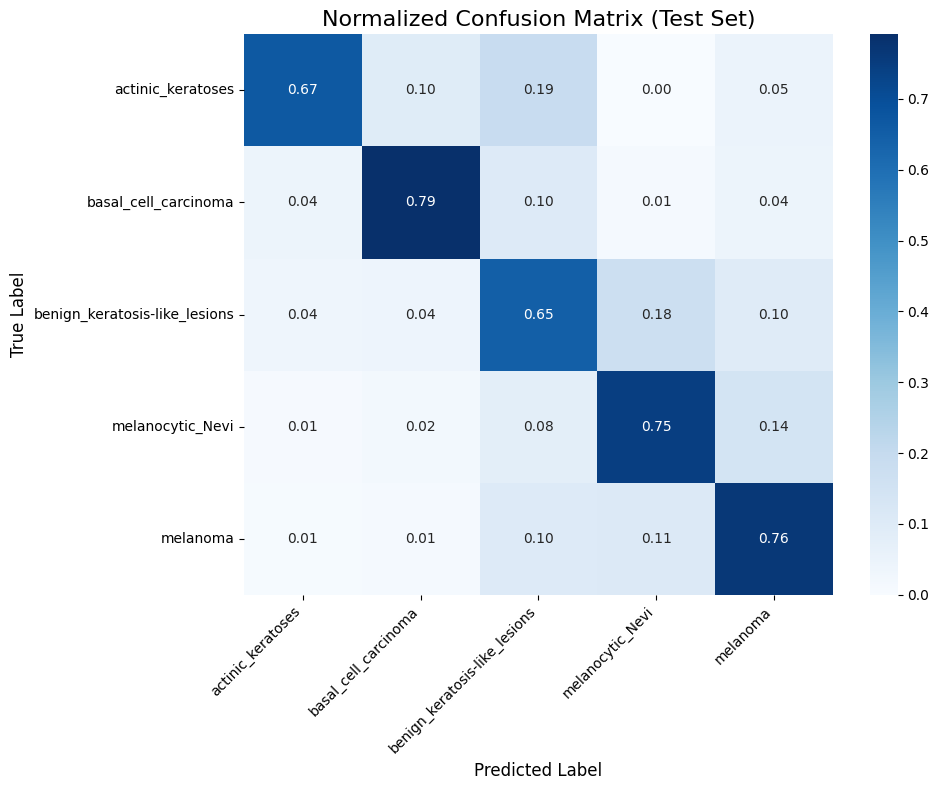


### 📈 ROC AUC Score (Multi-class One-vs-Rest)


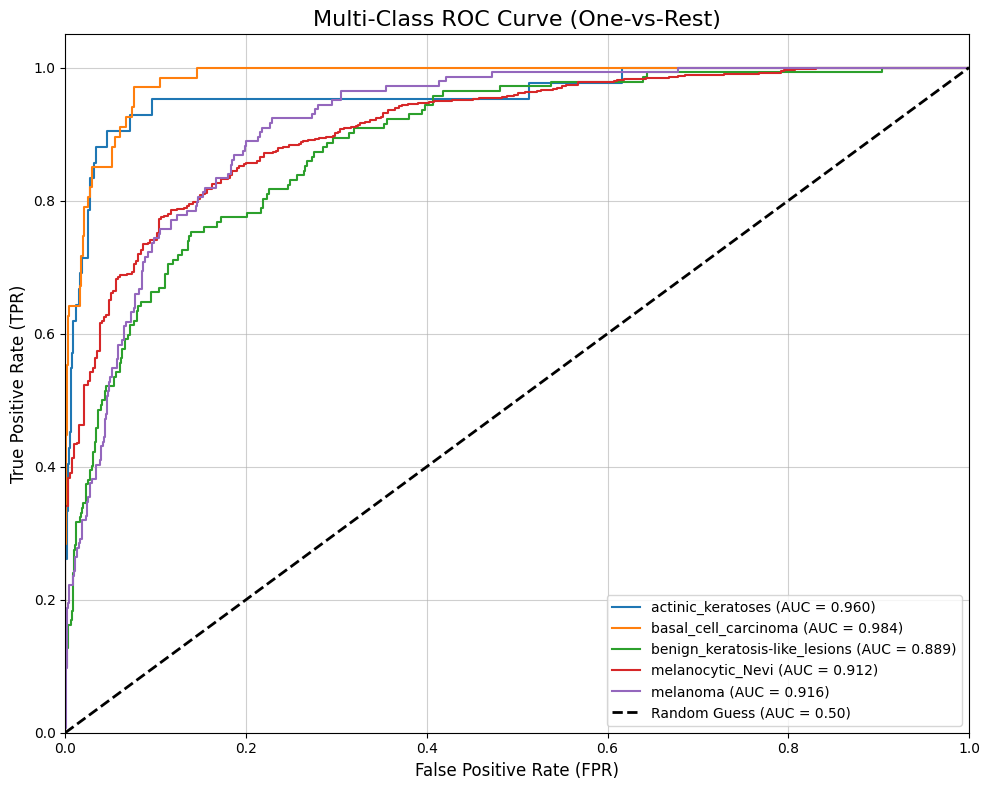

In [14]:

# Cell 4: Evaluate on Test Set

# Load best weights
try:
    model.load_weights('best_hybrid_skin_model.h5')
    print("✅ Loaded best model weights.")
except Exception as e:
    print(f"⚠️ Error loading weights: {e}")

# Generate Predictions
print("\n### 📉 Generating Predictions on Test Set...")
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
test_generator.reset()
Y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)

Y_pred = np.argmax(Y_pred_proba, axis=1)
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\n### 📋 Classification Report")
print(classification_report(Y_true, Y_pred, target_names=class_labels, digits=4))

# Confusion Matrix
print("\n### 📊 Confusion Matrix")
cm = confusion_matrix(Y_true, Y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve
print("\n### 📈 ROC AUC Score (Multi-class One-vs-Rest)")
Y_true_binarized = label_binarize(Y_true, classes=np.arange(len(class_labels)))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Multi-Class ROC Curve (One-vs-Rest)', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.6)
plt.tight_layout()
plt.show()

✅ Loaded best weights for prediction.


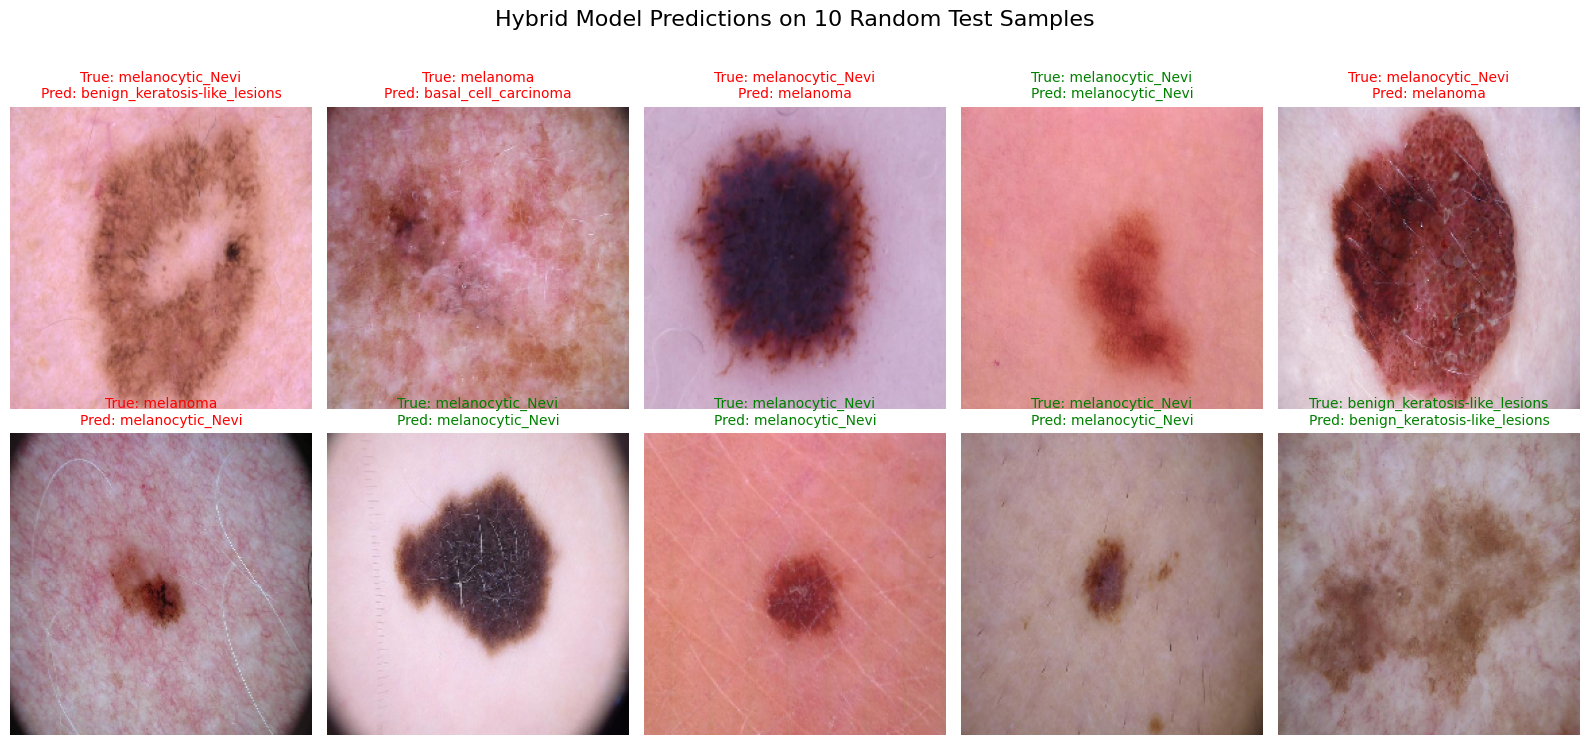

In [10]:

# Cell 5: Visual Prediction Test (10 Random Samples)

from tensorflow.keras.preprocessing import image

NUM_SAMPLES = 10

# Load best model weights
try:
    model.load_weights('best_hybrid_skin_model.h5')
    print("✅ Loaded best weights for prediction.")
except Exception as e:
    print(f"⚠️ Error: {e}")

# Get test data
test_filepaths = test_generator.filepaths
test_true_indices = test_generator.classes
class_names = list(test_generator.class_indices.keys())
total_test_samples = len(test_filepaths)

# Sample random images
np.random.seed(42)
sampled_indices = np.random.choice(total_test_samples, size=NUM_SAMPLES, replace=False)

sampled_images = []
sampled_true_labels_indices = []

for i in sampled_indices:
    path = os.path.join(test_generator.directory, test_filepaths[i])
    img = image.load_img(path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array_rescaled = img_array / 255.0
    sampled_images.append(img_array_rescaled)
    sampled_true_labels_indices.append(test_true_indices[i])

sampled_batch = np.array(sampled_images)

# Predict
predictions_proba = model.predict(sampled_batch, verbose=0)
predictions_indices = np.argmax(predictions_proba, axis=1)

# Visualize
plt.figure(figsize=(16, 8))

for i in range(NUM_SAMPLES):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sampled_batch[i])
    plt.axis('off')
    
    true_label = class_names[sampled_true_labels_indices[i]]
    predicted_label = class_names[predictions_indices[i]]
    color = 'green' if true_label == predicted_label else 'red'
    
    title = f"True: {true_label}\nPred: {predicted_label}"
    plt.title(title, color=color, fontsize=10)

plt.suptitle(f"Hybrid Model Predictions on {NUM_SAMPLES} Random Test Samples", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




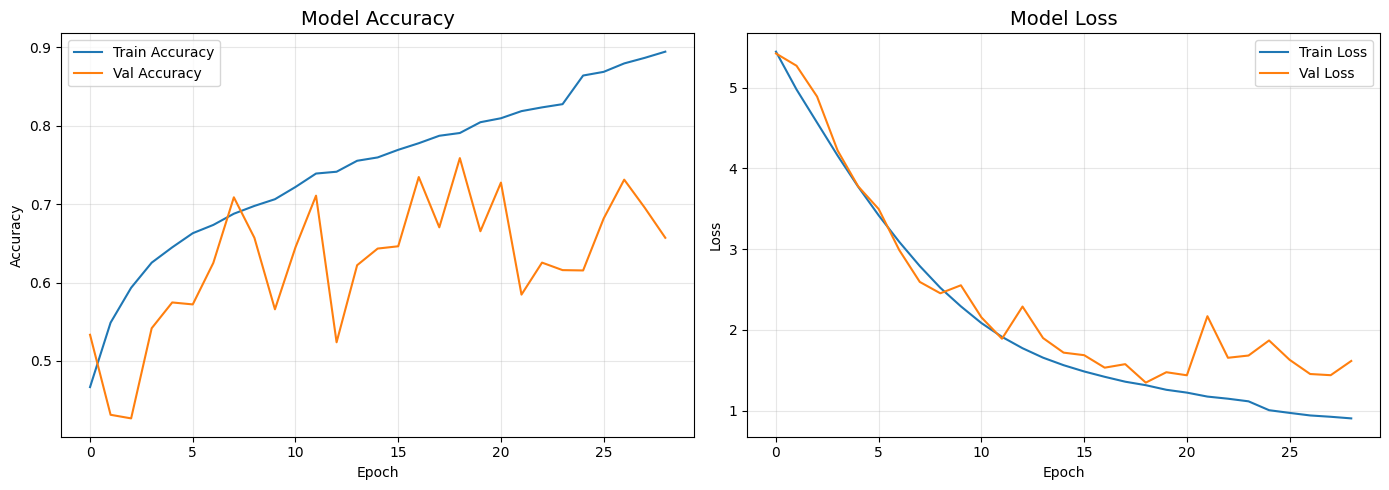

In [11]:
# Cell 6: Training History Visualization

# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()